# Actor-Critic

Actor-critic methods are Temporal Difference(TD) versions of Policy gradient methods that have a separate memory structure to explicitly represent the policy independent of the value function,
i.e. it is a reinforcement-learning technique in which you simultaneously learn a policy function and a value function.
The policy structure is known as the actor, because it is used to select actions, and the estimated value function is known as the critic, because it criticizes the actions made by the actor. Learning is always on-policy: the critic must learn about and critique whatever policy is currently being followed by the actor. The critique takes the form of a TD error. This scalar signal is the sole output of the critic and drives all learning in both actor and critic.

![actor critic](./images/actor_critic.jpg)


## Motivation
We derived policy gradients and saw the REINFORCE algorithm: \
![policy_gradient](./images/policy_gradient.jpg) 

However, there are some issues with vanilla policy gradients: 
1. Policy gradient is **high variance** and suffers from **noisy gradients**.
2. Convergence in policy gradient algorithms is **slow**.
3. Policy gradient is terribly **sample inefficient** (common in many different RL algorithms).

As in the REINFORCE algorithm, we update the policy parameter through MC updates (i.e. taking random samples). This introduces in inherent high variability in log probabilities (log of the policy distribution) and cumulative reward values, because each trajectories during training can deviate from each other at great degrees.

Consequently, the high variability in log probabilities and cumulative reward values will make noisy gradients, and cause unstable learning and/or the policy distribution skewing to a non-optimal direction.

Besides high variance of gradients, another problem with policy gradients occurs trajectories have a cumulative reward of 0. The essence of policy gradient is increasing the probabilities for “good” actions and decreasing those of “bad” actions in the policy distribution; both “goods” and “bad” actions with will not be learned if the cumulative reward is 0.

Overall, these issues contribute to the instability and slow convergence of vanilla policy gradient methods.


## Reducing variance with a baseline
One way to reduce variance and increase stability is subtracting the cumulative reward by a baseline: \
![baseline](./images/baseline.jpg) 

Intuitively, making the cumulative reward smaller by subtracting it with a baseline will make smaller gradients, and thus smaller and more stable updates.

Here is a very illustrative explanation, taken from [Jerry Liu’s post to “Why does the policy gradient method have high variance”](https://www.quora.com/unanswered/Why-does-the-policy-gradient-method-have-a-high-variance): \
![high_variance](./images/high_variance.jpg) 

### Common baseline functions
The baseline can take various values. The set of equations below illustrates the classic variants of actor critic methods (with respect to REINFORCE): \
![baseline_functions](./images/baseline_functions.jpg) 

## Q Actor Critic
We observe the vanilla policy gradient and recall that: \
![policy_gradient](./images/policy_gradient.jpg) 

We can then decompose the expectation into: \
![policy_gradient_decompose](./images/policy_gradient_decompose.jpg) 

The second expectation term is acctually the Q value! \
![q_value](./images/q_value.jpg)

Plugging that in, we can rewrite the update equation as: \
![policy_gradient_with_q_value](./images/policy_gradient_with_q_value.jpg)

This leads us to *Actor Critic Methods*, where:
1. The “Critic” estimates the value function. This could be the action-value (the Q value) or state-value (the V value).
2. The “Actor” updates the policy distribution in the direction suggested by the Critic (such as with policy gradients).

and both the Critic and Actor functions are parameterized. In the derivation above, the Critic parameterizes the Q value — so, it is called Q Actor Critic. \
![q_actor_critic](./images/q_actor_critic.jpg)

## Advantage Actor Critic
Using the $V$ function as the baseline function, we can also subtract the $Q$ value term with the $V$ value. Intuitively, this means *how much better it is to take a specific action compared to the average, general action at the given state*. We denote this value the advantage value: \
![advantage](./images/advantage.jpg)

Does that mean we have to learn both the $Q$ value and the $V$ value (in addition to the policy network)? No. That would be very inefficient. Instead, we can use the relationship between the $Q$ and the $V$ from the Bellman optimality equation:\
![q_v_relation](./images/q_v_relation.jpg)

and rewrite the advantage as:\
![advantage2](./images/advantage2.jpg)

Thus, we only have to learn the $V$ function (parameterized by $v$ above). So we can rewrite the update equation as: \
![advantage_actor_critic](./images/advantage_actor_critic.jpg)

# Implementation

## Simple V2 Environment
We begin with some imports:

In [1]:
import sys
import torch  
from pettingzoo.mpe import simple_v2
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

We define hyperparameters for our DNN networks (one for the Actor and one for the Critic)

In [2]:
# hyperparameters
hidden_size = 512
learning_rate = 3e-4

# Constants
GAMMA = 0.99
max_episodes = 3000

We define the DNN architectures:

In [3]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

and some helper functions 

In [4]:
def extract(d):
    return list(d.values())[0]

Our main function to train the Actor Critic model receives the environment and the number of desired inputs and outputs:

In [5]:
def train_a2c(env, agent_str, num_inputs, num_outputs, n_steps=np.inf):
    """
    If n_steps is given, the training will run until the game ends or up to the number of steps
    """
    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    all_rewards = []
    entropy_term = 0

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        _state = env.reset()
        state = _state[agent_str]
        done = False
        step = 0
        while not done and step < n_steps:
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step({agent_str: action})
            
            reward = extract(reward)
            new_state = extract(new_state)
            done = extract(done)
            
            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state
            
            step += 1
            
        Qval, _ = actor_critic.forward(new_state)
        Qval = Qval.detach().numpy()[0,0]
        all_rewards.append(np.sum(rewards))
        if episode % 100 == 0:                    
            sys.stdout.write("episode: {}, reward: {} \n".format(episode, np.sum(rewards)))
        
        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval
  
        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)
        
        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

        
    
    # Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

We are now ready to train our model:

episode: 0, reward: -96.55034250214538 
episode: 100, reward: -22.45944580487929 
episode: 200, reward: -83.93865110452285 
episode: 300, reward: -19.793747047434994 
episode: 400, reward: -79.15135541525656 
episode: 500, reward: -8.965970612973475 
episode: 600, reward: -6.31573701316942 
episode: 700, reward: -47.120057124564326 
episode: 800, reward: -25.871763777981684 
episode: 900, reward: -32.851006597162154 
episode: 1000, reward: -10.837730596796728 
episode: 1100, reward: -14.661030112665813 
episode: 1200, reward: -18.58759716492385 
episode: 1300, reward: -3.861224641420754 
episode: 1400, reward: -13.285592073347988 
episode: 1500, reward: -1.390029373270746 
episode: 1600, reward: -13.346939610828539 
episode: 1700, reward: -6.4972043755999636 
episode: 1800, reward: -13.84554327193837 
episode: 1900, reward: -4.775231007542845 
episode: 2000, reward: -5.360640953087309 
episode: 2100, reward: -6.59046109306863 
episode: 2200, reward: -4.733242527755085 
episode: 2300, r

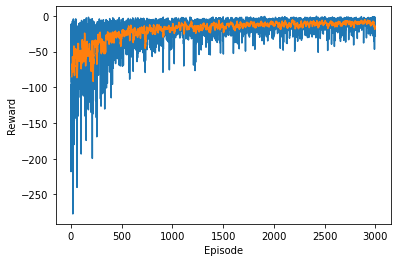

In [6]:
simple_env = simple_v2.parallel_env(max_cycles=40,continuous_actions=False)
agent_str = simple_env.possible_agents[0]
num_inputs = simple_env.observation_space(agent_str).shape[0]
num_outputs = simple_env.action_space(agent_str).n
train_a2c(simple_env, agent_str, num_inputs, num_outputs)

## MultiTaxi Environment
Once again we begin with some imports:

In [7]:
import numpy as np
from multi_taxi.taxi_environment import simple_MAP
from multi_taxi import MultiTaxiEnv
from IPython.display import clear_output

Our first scenario is a pickup only in the simple_MAP environment:

In [8]:
taxi_env = MultiTaxiEnv(num_taxis=1, num_passengers=1, pickup_only=True, can_see_others=False, domain_map=simple_MAP)
taxi_env.render()

+---------+
| : : : : |
| : : : : |
|_: : : : |
| : : : :P|
| : : : : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (2,0), Collided: False
Passenger1: Location: (3, 4), Destination: pickup only!
Done: False, {'taxi_0': False, '__all__': False}
Passengers Status's: [2]


We train our Actor Critic model:

episode: 0, reward: -50 
episode: 100, reward: -50 
episode: 200, reward: 74 
episode: 300, reward: 64 
episode: 400, reward: 52 
episode: 500, reward: -50 
episode: 600, reward: 61 
episode: 700, reward: 83 
episode: 800, reward: 96 
episode: 900, reward: 73 
episode: 1000, reward: 79 
episode: 1100, reward: 68 
episode: 1200, reward: 87 
episode: 1300, reward: 64 
episode: 1400, reward: 94 
episode: 1500, reward: 90 
episode: 1600, reward: 92 
episode: 1700, reward: 88 
episode: 1800, reward: 99 
episode: 1900, reward: 97 
episode: 2000, reward: 97 
episode: 2100, reward: 92 
episode: 2200, reward: 94 
episode: 2300, reward: 96 
episode: 2400, reward: 95 
episode: 2500, reward: 96 
episode: 2600, reward: 97 
episode: 2700, reward: 97 
episode: 2800, reward: 92 
episode: 2900, reward: 95 


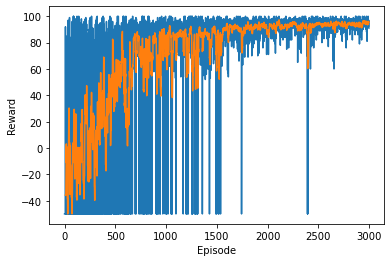

In [9]:
agent_str = taxi_env.taxis_names[0]
num_inputs = taxi_env.observation_space.shape[0]
num_outputs = taxi_env.action_space.n
train_a2c(taxi_env, agent_str, num_inputs, num_outputs, n_steps=50)

A more challenging scenario includes dropoff:

In [10]:
taxi_env = MultiTaxiEnv(num_taxis=1, num_passengers=1, pickup_only=False, can_see_others=False, domain_map=simple_MAP)
taxi_env.render()

+---------+
| : : : : |
|D: : : :P|
| :_: : : |
| : : : : |
| : : : : |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (2,1), Collided: False
Passenger1: Location: (1, 4), Destination: (1, 0)
Done: False, {'taxi_0': False, '__all__': False}
Passengers Status's: [2]


episode: 0, reward: -30 
episode: 100, reward: -30 
episode: 200, reward: -30 
episode: 300, reward: -30 
episode: 400, reward: -30 
episode: 500, reward: -30 
episode: 600, reward: -30 
episode: 700, reward: -30 
episode: 800, reward: -30 
episode: 900, reward: -30 
episode: 1000, reward: -30 
episode: 1100, reward: -30 
episode: 1200, reward: -30 
episode: 1300, reward: -30 
episode: 1400, reward: -30 
episode: 1500, reward: -30 
episode: 1600, reward: -30 
episode: 1700, reward: -30 
episode: 1800, reward: -30 
episode: 1900, reward: -30 


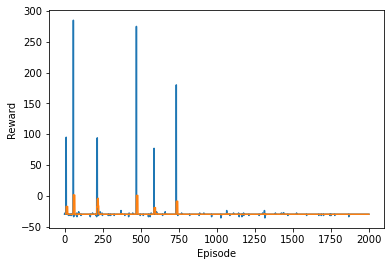

In [11]:
max_episodes = 2000
agent_str = taxi_env.taxis_names[0]
num_inputs = taxi_env.observation_space.shape[0]
num_outputs = taxi_env.action_space.n
train_a2c(taxi_env, agent_str, num_inputs, num_outputs, n_steps=30)